In [16]:
#Import all required functions required for the 2D-DRP for this notebook.
#(Running this code block is NOT required if FRD and PSF inputs are generated otherwise

#Note the testfile{}.csv files must be included if generating images with the 2D-DRP

############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/brentbelland/Desktop/Version_028d/2d_PSF_code/'
############################################################
    
TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'

# create these directories if they do not exist
import os
for i in [PSF_DIRECTORY,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)

from __future__ import absolute_import, division, print_function
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

# lmfit 
# import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c

import Zernike_Module
from Zernike_Module_v034b import *

In [9]:
## Required imports for FRDsolver code

import numpy as np
import pandas as pd #Is this truly required?
from scipy.ndimage.measurements import center_of_mass #This function is imported in order to measure changes about the center of the PSF.
from scipy import interpolate #Is this required?
import warnings

In [25]:
## FRD solver code

class FRDsolver(object):
    """FRD solver function for PSF inputs"""
    
    def __init__(self, FRDlist, knownimagelist, imagetosolve):
        """Generates a FRDsolver object"""
        
        self._checkFRDlist(FRDlist)
        self._checkimagelists(knownimagelist,imagetosolve)
        self._checklengths(FRDlist,knownimagelist)
        
        self.FRDlist = FRDlist
        self.knownimagelist = knownimagelist
        self.imagetosolve = imagetosolve

        
    def _checkFRDlist(self,FRDlist):
        """Validates the input FRD list"""
        
        if not isinstance(FRDlist,np.ndarray):
            raise Exception('FRDlist should be a np.ndarray')
            
        if not np.array_equal(FRDlist,np.sort(FRDlist)):
            warnings.warn('FRDlist is not sorted!')  

    def _checkimagelists(self,knownimagelist,imagetosolve):
        """Validates the input images"""
        
        if not isinstance(knownimagelist,np.ndarray):
            raise Exception('knownimagelist should be a np.ndarray')
        
        if not isinstance(imagetosolve,np.ndarray):
            raise Exception('imagetosolve should be a np.ndarray')
            
        for image in knownimagelist:
            if np.shape(image) != np.shape(imagetosolve):
                raise Exception('The input images of known FRD should have the same dimensions as the image to solve.')  
        
    def _checklengths(self, FRDlist, knownimagelist):
        "Verifies that the FRD inputs match the inputted images"
        
        if not len(FRDlist) == len(knownimagelist):
            raise Exception('The length of FRDlist is not equal to the length of knownimagelist. Make sure each image has a corresponding FRD.')
            
        if len(FRDlist) == 0:
            raise Exception('At least one FRD must be input!')
        
        if len(FRDlist) == 1:
            warnings.warn('No meaningful result will occur when only one comparison FRD value is given.')

    def residual_calculate(self,imagetosolve,guessimage):
    
        residualval = 0
        currentimage = imagetosolve 
        modeltocompare = guessimage 
            
        centery, centerx = center_of_mass(currentimage) #Determine the center of the PSF. Ordered y, x as it would appear in imshow() but most important thing is to be consistent with ordering
        centery = int(np.round(centery)) #Rounded to permit easier pixel selection. But as is obvious, "easier" does not necesssarily translate to "better". #Debugging, to be removed
        centerx = int(np.round(centerx))
    
        residualval += np.sum(np.divide(np.square(currentimage[(centery-3):(centery+3),(centerx-3):(centerx+3)]-modeltocompare[(centery-3):(centery+3),(centerx-3):(centerx+3)]),(modeltocompare[(centery-3):(centery+3),(centerx-3):(centerx+3)])))
        residualval -= np.sum(np.divide(np.square(currentimage[(centery-1):(centery+1),(centerx-1):(centerx+1)]-modeltocompare[(centery-1):(centery+1),(centerx-1):(centerx+1)]),(modeltocompare[(centery-1):(centery+1),(centerx-1):(centerx+1)])))

        return residualval            
            
    def find_FRD_compare_positions(self, FRDlist, knownimagelist, imagetosolve):
        """MinFRD = find_FRD_compare_positions(self, FRDlist, knownimagelist, imagetosolve)
        Solves for minimal FRD and returns it
        
        Parameters
        -----------
    
        imagetosolve: array
            PSF image with unknown FRD.
        
    
        imagelist: list
            A list of PSF image arrays of known FRDs
        
    
        position: list
            A list of positions from the same fiber to be used to find FRD. 
    
        
        FRDarray: list
            A list of FRDs of the corresponding PSF image arrays in imagelist

        """
        
        
        #Begin with validation of the inputs
        self._checkFRDlist(FRDlist)
        self._checkimagelists(knownimagelist,imagetosolve)
        self._checklengths(FRDlist, knownimagelist)
            
        residuallist = []
        minFRD = np.nan
    
        for FRDindex in range(len(FRDlist)):
            residual_current = self.residual_calculate(imagetosolve,imagelist[FRDindex])
            residuallist.append(self.residual_calculate(imagetosolve,imagelist[FRDindex]))
            if residual_current == np.min(residuallist):
                minFRD = FRDlist[FRDindex] #Still need to return the metric
        
        if np.isnan(minFRD):
            raise Error('No FRD residuals were calculated.')
        
        return (residuallist,minFRD)
    
    
    """ def _find_FRD_compare_positions(imagetosolve, imagelist,position,FRDarray):
        MinFRD = find_FRD_compare_positions(imagetosolve, imagelist)
        Runs the shgo minimization algorithm to test for the minimum FRD fitting
    
        Parameters
        -----------
    
        imagetosolve: array
            PSF image with unknown FRD.
        
    
        imagelist: list
            A list of PSF image arrays of known FRDs
        
    
        position: list
            A list of positions from the same fiber to be used to find FRD. 
    
        
        FRDarray: list
            A list of FRDs of the corresponding PSF image arrays in imagelist

        bounds = [(0.015, 0.030)] #could make the FRD bounds an independent input, especially if interpolation is not viable external to generation. Instead could use bounds of input FRDarray
        res = shgo(residual_compare,bounds,args=([position,FRDarray,imagelist,imagetosolve]),n=10,options={'ftol':1e-5, 'maxev':10}) #Minimization algorithm.
        #print(res)
        return res.x   """ 


In [20]:
## Set up input images


##Change these values to modify the output

positionvalt = 64
FRDrealt = 0.023
knownFRDlist = np.linspace(0.015,0.030)

##Function defintions to generate images

def get_PSF_parameters(FRDval,Defocusval,Positionval):
    testfile = pd.read_csv("testfile{}.csv".format(Defocusval))
    testfile = testfile.iloc[Positionval]
    testfile['z4':'z22']= testfile['z4':'z22']
    testfile['frd_sigma'] = FRDval
    PSF_parameters = testfile.values
    PSF_parameters = PSF_parameters[:-2]
    return PSF_parameters

def generate_specific_image_position(position,FRD):
    sci_image = 10*np.random.rand(50,50)
    var_image = sci_image
    model3 = LN_PFS_single(sci_image,var_image,dithering=1,save=0,zmax=22,verbosity=0,npix=1536)
    #FRD = 0.015+0.015*np.random.rand()
    res=model3(get_PSF_parameters(FRD,'0',position),return_Image=True) #Position is arbitrarily set by random sci_image input and Neven's code
    In_focus = res[1]

    return In_focus

def generate_image_of_known_FRD(imagetosolve,arrayofFRD,positionvalue):
    imagearrayofFRD = []
    for FRD in arrayofFRD:
        #print(FRD)
        newimage = get_model_image_compare_position(imagetosolve,FRD,positionvalue)
        imagearrayofFRD.append(newimage)
    return imagearrayofFRD

def get_model_image_compare_position(science_image,guessFRD,position):
    #if isinstance(science_image[0][0],list):
    #    print(science_image)
    variance_image = 0.99*science_image+40*np.ones(np.shape(science_image))
    model4 = LN_PFS_single(science_image,variance_image,dithering=1,save=0,zmax=22,verbosity=0,npix=1536,fit_for_flux=True)
    res=model4(get_PSF_parameters(guessFRD,'0',position),return_Image=True) #xy position is fit for by Neven's code
    In_focus = res[1]
    #print(res[-1])
    
    return In_focus

## Generation of the images and FRD list 

newimaget = generate_specific_image_position(positionvalt,FRDrealt) # This is the image to test against.
imagerealt = 50000000/np.sum(newimaget)*newimaget #Flux calibration
imagelist = generate_image_of_known_FRD(imagerealt,knownFRDlist,positionvalt)

In [30]:
## Class testing

#Case 1: FRDlist length does not match imagelist length

FRDmismatch = FRDsolver(np.array([0.25, 0.27]), np.array([imagerealt, imagerealt]), np.array([[2,2], [3,4]]))

Exception: The input images of known FRD should have the same dimensions as the image to solve.

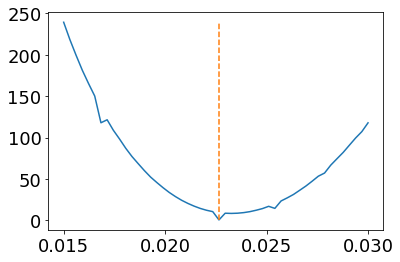

In [23]:
## Example class test

testFRD = FRDsolver(knownFRDlist, np.array(imagelist), imagerealt)

(residuallist, minFRD) = testFRD.find_FRD_compare_positions(knownFRDlist, np.array(imagelist), imagerealt)

plt.plot(knownFRDlist,residuallist)
plt.plot([minFRD,minFRD],[np.min(residuallist),np.max(residuallist)],'--')